# AnomalyDetection using Independent-Univariate and Multivariate Analysis# 

##### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math

In [2]:
# Special Thanks to https://github.com/abhishek-Kumar009/Machine-Learning/tree/master/AnomalyDetectionScratch
# for the dataset and parent code.

# Please note: This code is an edited version by Deepesh Wadhwani. He corrected some errors in evaluation the 
# multivariate gaussian probability distribution. Also Arranged the code to facilitate explanationation of the algorithm.

In [3]:
# import dataset as:
# 60% TRAIN SET = X
# 20% VAL Set inclusing half of positive examples = Xval, y_val
# 20% as TEST SET including othr half of positive examples = Xtest, ytest


dataset = sio.loadmat('anomalyData.mat')
X = dataset['X']

Xval = dataset['Xval']
y_val = dataset['yval']

In [4]:
print(X.shape)

(307, 2)


Text(0, 0.5, 'X2')

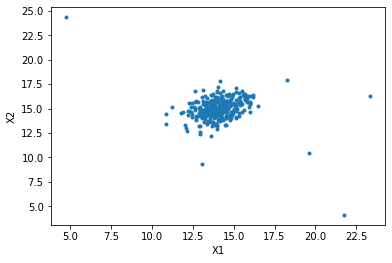

In [5]:
plt.scatter(X[:, 0], X[:, 1], marker = ".")
plt.xlabel('X1')
plt.ylabel('X2')

In [6]:
def estimate_Gaussian(X):
    n = np.size(X, 1)
    m = np.size(X, 0)
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    
    mu = np.reshape((1/m)*np.sum(X, 0), (1, n))
    sigma2 = np.reshape((1/m)*np.sum(np.power((X - mu),2), 0),(1, n))
    
    return mu, sigma2



In [7]:

def estimate_I_univariate_Probability(X, mu, sigma2):
    
    n = np.size(X, 1)
    m = np.size(X, 0)
      

    sigma2 = np.diag(sigma2[0, :])
    
    X = X - mu
    pi = math.pi
    
    det = np.linalg.det(sigma2)
    inv = np.linalg.inv(sigma2)
    val = np.reshape((-0.5)*np.sum(np.multiply((X@inv),X), 1),(np.size(X, 0), 1))
    
    p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)
    
    return p

In [8]:
mu, sigma2 = estimate_Gaussian(X)
print('mean: ',mu,' variance: ',sigma2)

mean:  [[14.11222578 14.99771051]]  variance:  [[1.83263141 1.70974533]]


In [9]:
p_uni = estimate_I_univariate_Probability(X, mu, sigma2)
print(p_uni.shape)

(307, 1)


In [10]:

def estimate_multivariate_Gaussian(X):
    
    n = np.size(X, 1)
    m = np.size(X, 0) 
     
     
    mu = np.reshape((1/m)*np.sum(X, 0), (1, n))
    sigma2 = np.cov(X, rowvar=False)
      
    return mu, sigma2

In [11]:
mu_m, sigma2_m = estimate_multivariate_Gaussian(X)
print('mean: ',mu_m,' variance: ',sigma2_m)

mean:  [[14.11222578 14.99771051]]  variance:  [[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


In [12]:

def estimate_multivariate_Probability(X, mu, sigma2):
    
    n = np.size(X, 1)
    m = np.size(X, 0)
     
    X = X - mu
    pi = math.pi
    det = np.linalg.det(sigma2)
    inv = np.linalg.inv(sigma2)
    val = np.reshape((-0.5)*np.sum(np.multiply((X@inv),X), 1),(np.size(X, 0), 1))
     
    p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)
     
    return p

In [13]:
p_multi = estimate_multivariate_Probability(X, mu_m, sigma2_m)
print(p_multi.size)

307


In [14]:
pval_univariate = estimate_I_univariate_Probability(Xval, *estimate_Gaussian(X))

In [15]:
pval_multivariate = estimate_multivariate_Probability(Xval, *estimate_multivariate_Gaussian(X))

In [16]:
print(pval_multivariate.size , pval_univariate.size)

307 307


In [17]:
pval_multivariate - pval_univariate

array([[ 1.73222897e-04],
       [ 1.26454241e-03],
       [-3.40470858e-03],
       [-2.37084471e-03],
       [ 2.33409334e-03],
       [ 4.11613383e-03],
       [-9.52075294e-04],
       [ 9.26145841e-04],
       [-2.49314578e-03],
       [ 6.40333905e-04],
       [-9.38785522e-04],
       [-9.02921008e-04],
       [ 3.51141806e-03],
       [-3.23234581e-03],
       [ 3.12464497e-03],
       [-4.01567900e-03],
       [ 3.61310398e-03],
       [-1.18299154e-03],
       [-9.29561329e-04],
       [-3.85782719e-03],
       [ 4.05676919e-04],
       [-4.27304219e-03],
       [ 3.61001654e-04],
       [-6.68075478e-04],
       [ 2.12665185e-03],
       [ 1.20284132e-03],
       [-4.02319646e-03],
       [ 2.01897977e-03],
       [-3.40893020e-03],
       [ 5.52742590e-04],
       [ 7.79651059e-04],
       [ 9.51589940e-04],
       [ 1.97583070e-03],
       [ 4.14075009e-04],
       [ 1.94502731e-04],
       [ 2.61826846e-04],
       [-1.70535649e-03],
       [-4.04778472e-03],
       [ 3.3

In [19]:
print((y_val==1).sum(), " ", (y_val==0).sum())

9   298


In [20]:
def selectThreshHold(yval, pval):
    
    F1 = 0
    bestF1 = 0
    bestEpsilon = 0
    
    stepsize = (np.max(pval) - np.min(pval))/1000
        
    epsVec = np.arange(np.min(pval), np.max(pval), stepsize)
    noe = len(epsVec)
    
    for eps in range(noe):
        epsilon = epsVec[eps]
        pred = (pval < epsilon)
        prec, rec = 0,0
        tp,fp,fn = 0,0,0
        
        try:
            for i in range(np.size(pval,0)):
                if pred[i] == 1 and yval[i] == 1:
                    tp+=1
                elif pred[i] == 1 and yval[i] == 0:
                    fp+=1
                elif pred[i] == 0 and yval[i] == 1:
                    fn+=1
            prec = tp/(tp + fp)
            rec = tp/(tp + fn)
            F1 = 2*prec*rec/(prec + rec)
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon
        except ZeroDivisionError:
            print('Warning dividing by zero!!')          
       
    return bestF1, bestEpsilon

In [21]:
F1_uni, epsilon_uni = selectThreshHold(y_val, pval_univariate)
print('For Univariate Epsilon and F1 are:',epsilon_uni, F1_uni)

Warning dividing by zero!!
For Univariate Epsilon and F1 are: 8.990852779269493e-05 0.8750000000000001


In [22]:
F1_multi, epsilon_multi = selectThreshHold(y_val, pval_multivariate)
print('For Multivariate Epsilon and F1 are:',epsilon_multi, F1_multi)

Warning dividing by zero!!
For Multivariate Epsilon and F1 are: 9.036240676156382e-05 0.8750000000000001


In [23]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [24]:
outl_uni = (pval_univariate < epsilon_uni)
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l
listOfOutliers_uni = findIndices(outl_uni)    


In [25]:
outl_multi = (pval_multivariate < epsilon_multi)
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l
listOfOutliers_multi = findIndices(outl_multi)  

In [26]:
print((outl_uni==True).sum(), " ", (outl_uni==False).sum())

7   300


In [27]:
print((outl_multi==True).sum(), " ", (outl_multi==False).sum())

7   300


In [28]:
count_outliers = len(listOfOutliers_uni)
print('\n\nFor Univariate Number of outliers:', count_outliers)
print('\n',listOfOutliers_uni)



For Univariate Number of outliers: 7

 [300, 301, 302, 303, 304, 305, 306]


In [29]:
count_outliers = len(listOfOutliers_multi)
print('\n\nFor Multivariate Number of outliers:', count_outliers)
print('\n',listOfOutliers_multi)



For Multivariate Number of outliers: 7

 [300, 301, 302, 303, 304, 305, 306]


In [30]:
actualoutl = (y_val == 1)
findIndices(actualoutl)

[9, 49, 300, 301, 302, 303, 304, 305, 306]

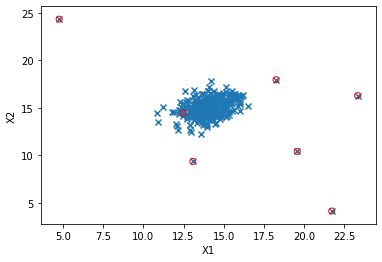

In [31]:

#if both work in same manner, we can use any to predict for test set

plt.scatter(X[:, 0], X[:, 1], marker = "x")
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(X[listOfOutliers_uni,0], X[listOfOutliers_uni, 1], facecolors = 'none', edgecolors = 'r')
plt.show()

Finally for the Test Set Prediction:

In [32]:
newDataset = sio.loadmat('anomalyDataTest.mat')

Xtest = newDataset['Xval']
ytest = newDataset['yval']

In [35]:
mutest, sigma2test = estimate_Gaussian(Xtest)
ptest = estimate_I_univariate_Probability(Xtest, mutest, sigma2test)

F1test, epsilontest = selectThreshHold(ytest, ptest)
print('\nBest epsilon and F1 are\n',epsilontest, F1test)

Warning dividing by zero!!

Best epsilon and F1 are
 1.6620587111948498e-18 0.6153846153846154


In [36]:
outliersTest = ptest < epsilontest
listOfOl = findIndices(outliersTest)

print('\n\nExpected Outliers are:\n',listOfOl)
print('\n\nNumber of outliers are: ',len(listOfOl))



Expected Outliers are:
 [0, 3, 6, 11, 19, 27, 34, 43, 50, 59, 60, 69, 71, 86, 88, 92]


Number of outliers are:  16


In [37]:
actualoutl = (ytest == 1)
list_Of_Ol = findIndices(actualoutl)

print('\n\nActual Outliers are:\n',list_Of_Ol)
print('\n\nNumber of outliers are: ',len(list_Of_Ol))



Actual Outliers are:
 [0, 3, 19, 27, 38, 59, 71, 88, 91, 92]


Number of outliers are:  10
